# Project 7: Airport Delays + Cluster Analysis

### Problem Statement:

You've been hired by the FAA as a consultant to analyze the operations of major airports around the country. The FAA wants to cut down on delays nationwide, and the most important part of this task is understanding the characteristics and groupings of airports based on a dataset of departure and operational delays.

- A certain degree of delay is expected in airport operations, however the FAA is noticing significant delays with certain airports
- When a flight takes off, it's departure delay is recorded in minutes, as well as operational data relating to this delay
- At the end of the year, this data is averaged out for each airport. Your datasets have these averaged for a 10 year range between 2004 and 2014
- Over this 10 year range, some delay times have not improved or have worsened.


###  Project Summary

In this project, we're going to be using three different datasets related to airport operations. These include a dataset detailing the arrival and departure delays/diversions by airport, a dataset that provides metrics related to arrivals and departures for each airport, and a dataset that details names and characteristics for each airport code.

You will help the FAA:

- Organize and store their data so that they can easily understand it after your consulting work is done
- Mine and refine the data to uncover its basic attributes and characteristics
- Use your skills with PCA to uncover the core components of operations related to delays.

When you've finished your analysis, the FAA would like a report detailing your findings, with recommendations as to which airports and operational characteristics they should target to decrease delays.

Here are some questions to keep in mind:

- What operational factors are most directly correlated to delays?
- Take a look at airports groupings - are there any relationships by region? Size?


## Load Data

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.set_cmap('jet')

In [2]:
airport_df = pd.read_csv("./assets/airports.csv")
airport_ops_df = pd.read_csv("./assets/Airport_operations.csv")
airport_cancels_df = pd.read_csv("./assets/airport_cancellations.csv")

In [3]:
from sqlalchemy import create_engine
def connect_to_postgres():
    user="postgres"
    password = "postgres"
    host = "localhost"
    dbname = "project7"
    port = "5432"
    connection = create_engine("postgresql://{}:{}@{}:{}/{}".format(user, password, host, port, dbname))
    #engine = create_engine("postgresql://{}:{}@{}:{}/{}".format(user, password, host, port, dbname))
    return connection

connection = connect_to_postgres()

In [4]:
airport_ops_df.to_sql("airport_operations", connection, schema="public",if_exists="replace", index=False)
airport_df.to_sql("airports", connection, schema="public",if_exists="replace", index=False)
airport_cancels_df.to_sql("airport_cancellations", connection, schema="public",if_exists="replace",index=False)

In [5]:
def load_data_from_table(connection,sql_query):
    df = pd.read_sql(sql_query,con=connection)
    return df

Preliminary analysis on Airport_df
1. Check few rows and columns 
2. Check the shape
3. Check null values

In [6]:
sql_query = """
    select * from airports
    """
airport_df = load_data_from_table(connection,sql_query)

In [7]:
airport_df.head(2)

,Key,LocID,AP_NAME,ALIAS,Facility Type,FAA REGION,COUNTY,CITY,STATE,AP Type,Latitude,Longitude,Boundary Data Available
0,3443.0,STX,HENRY E ROHLSEN,Henry E Rohlsen Int'l Airport,Airport,ASO,-VIRGIN ISLANDS-,CHRISTIANSTED,VI,Public Use,17.701556,-64.801722,Yes
1,5088.0,X64,PATILLAS,None,Airport,ASO,#NAME?,PATILLAS,PR,Public Use,17.982189,-66.019330,No


In [8]:
print airport_df.shape
pd.DataFrame(airport_df.isnull().sum()).T

(5167, 13)


,Key,LocID,AP_NAME,ALIAS,Facility Type,FAA REGION,COUNTY,CITY,STATE,AP Type,Latitude,Longitude,Boundary Data Available
0,3,15,3,1669,3,3,3,3,3,3,3,3,3


Preliminary Analysis on Airport Operations
1. Check few rows, columns
2. Check shape of the data
3. Check null values 
4. Check number of unique airports
5. describe the dataset

In [9]:
sql_query = """
    select * from airport_operations
    """
airport_ops_df = load_data_from_table(connection,sql_query)

In [10]:
airport_ops_df.head(5)

,airport,year,departures for metric computation,arrivals for metric computation,percent on-time gate departures,percent on-time airport departures,percent on-time gate arrivals,average_gate_departure_delay,average_taxi_out_time,average taxi out delay,average airport departure delay,average airborne delay,average taxi in delay,average block delay,average gate arrival delay
0,ABQ,2004,53971,53818,0.8030,0.7809,0.7921,10.38,9.89,2.43,12.10,2.46,0.83,2.55,10.87
1,ABQ,2005,51829,51877,0.8140,0.7922,0.8001,9.60,9.79,2.29,11.20,2.26,0.89,2.34,10.24
2,ABQ,2006,49682,51199,0.7983,0.7756,0.7746,10.84,9.89,2.16,12.33,2.12,0.84,2.66,11.82
3,ABQ,2007,53255,53611,0.8005,0.7704,0.7647,11.29,10.34,2.40,12.95,2.19,1.29,3.06,12.71
4,ABQ,2008,49589,49512,0.8103,0.7844,0.7875,10.79,10.41,2.41,12.32,1.82,1.03,2.79,11.48


In [11]:
print "No of rows and columns",airport_ops_df.shape
print "No of Airports",airport_ops_df.airport.nunique()
pd.DataFrame(airport_ops_df.isnull().sum()).T

No of rows and columns (841, 15)
No of Airports 77


,airport,year,departures for metric computation,arrivals for metric computation,percent on-time gate departures,percent on-time airport departures,percent on-time gate arrivals,average_gate_departure_delay,average_taxi_out_time,average taxi out delay,average airport departure delay,average airborne delay,average taxi in delay,average block delay,average gate arrival delay
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Preliminary analysis on Airport Cancellations
1. Check few rows, columns
2. check shape
3. check null values

In [12]:
sql_query = """
    select * from airport_cancellations
    """
airport_cancels_df = load_data_from_table(connection,sql_query)

In [13]:
airport_cancels_df.head(2)

,Airport,Year,Departure Cancellations,Arrival Cancellations,Departure Diversions,Arrival Diversions
0,ABQ,2004.0,242.0,235.0,71.0,46.0
1,ABQ,2005.0,221.0,190.0,61.0,33.0


In [14]:
print "No of rows and columns", airport_cancels_df.shape
print "No of unique airports", airport_cancels_df["Airport"].nunique()
pd.DataFrame(airport_cancels_df.isnull().sum()).T

No of rows and columns (805, 6)
No of unique airports 74


,Airport,Year,Departure Cancellations,Arrival Cancellations,Departure Diversions,Arrival Diversions
0,0,0,0,0,0,0


### Merge Airport data frames

1. airport_ops_df and airport_cancels_df (**airport_operations_df**)

    1.1 trim spaces in the airport columns

    1.2 convert airport_cancels_df Year column to integer

    1.3 Merge on **Airport** and **year** columns with left join on **airport_ops_df**
    
    1.4 Delete **Airport** and **year** columns as they are duplicate

2. airport_operations_df and airport (**airport_merged_df**) for longitude, latitude, county, city

    2.1 trim spaces in the LocID columns
    
    2.2. merge on **airport** and **locID** with left join on **airport_operations_df**
    
    2.3  remove columns that are not necessary


In [15]:
# airport_ops_df["airport"] = airport_ops_df["airport"].str.strip()
# airport_cancels_df["Airport"] = airport_cancels_df["Airport"].str.strip()
# airport_cancels_df["Year"] =  airport_cancels_df["Year"].astype(int)

In [16]:
sql_query = """
    select t1.*, 
        t2."Departure Cancellations", 
        t2."Arrival Cancellations", 
        t2."Departure Diversions", 
        t2."Arrival Diversions",
        t3."Longitude",
        t3."Latitude"
    from airport_operations as t1 
    left join airport_cancellations as t2 on t1."airport" = t2."Airport" and t1."year" = t2."Year" 
    left join airports as t3 on t3."LocID" = t2."Airport"  
    """
airport_merged_df = load_data_from_table(connection,sql_query)

In [17]:
airport_merged_df.shape

(841, 21)

In [18]:
airport_merged_df.columns

Index([u'airport', u'year', u'departures for metric computation',
       u'arrivals for metric computation', u'percent on-time gate departures',
       u'percent on-time airport departures', u'percent on-time gate arrivals',
       u'average_gate_departure_delay', u'average_taxi_out_time',
       u'average taxi out delay', u'average airport departure delay',
       u'average airborne delay', u'average taxi in delay',
       u'average block delay', u'average gate arrival delay',
       u'Departure Cancellations', u'Arrival Cancellations',
       u'Departure Diversions', u'Arrival Diversions', u'Longitude',
       u'Latitude'],
      dtype='object')

In [19]:
airport_merged_df.dropna(axis=0, inplace=True)

In [20]:
airport_merged_df.shape

(799, 21)

In [21]:
airport_merged_df.corr()["average airport departure delay"].sort_values()

percent on-time airport departures   -0.954832
percent on-time gate departures      -0.764464
percent on-time gate arrivals        -0.712975
year                                 -0.023332
Latitude                              0.240283
Departure Diversions                  0.360954
arrivals for metric computation       0.390470
departures for metric computation     0.391838
Arrival Diversions                    0.444050
Arrival Cancellations                 0.487547
average taxi in delay                 0.504119
Departure Cancellations               0.504939
Longitude                             0.506213
average airborne delay                0.554790
average block delay                   0.589096
average_taxi_out_time                 0.688469
average taxi out delay                0.733528
average gate arrival delay            0.838877
average_gate_departure_delay          0.886479
average airport departure delay       1.000000
Name: average airport departure delay, dtype: float64

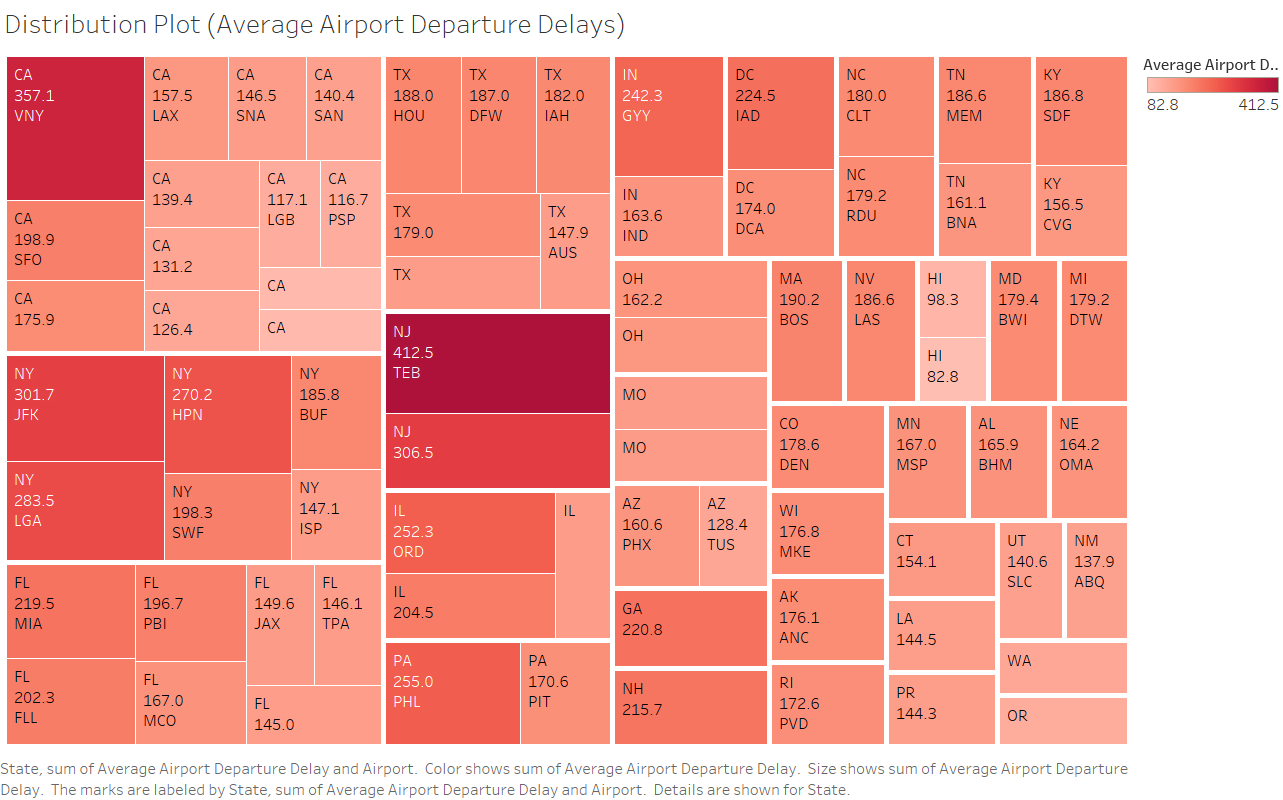

In [22]:
from IPython.display import Image
Image(filename='./assets/images/project07_1.png') 

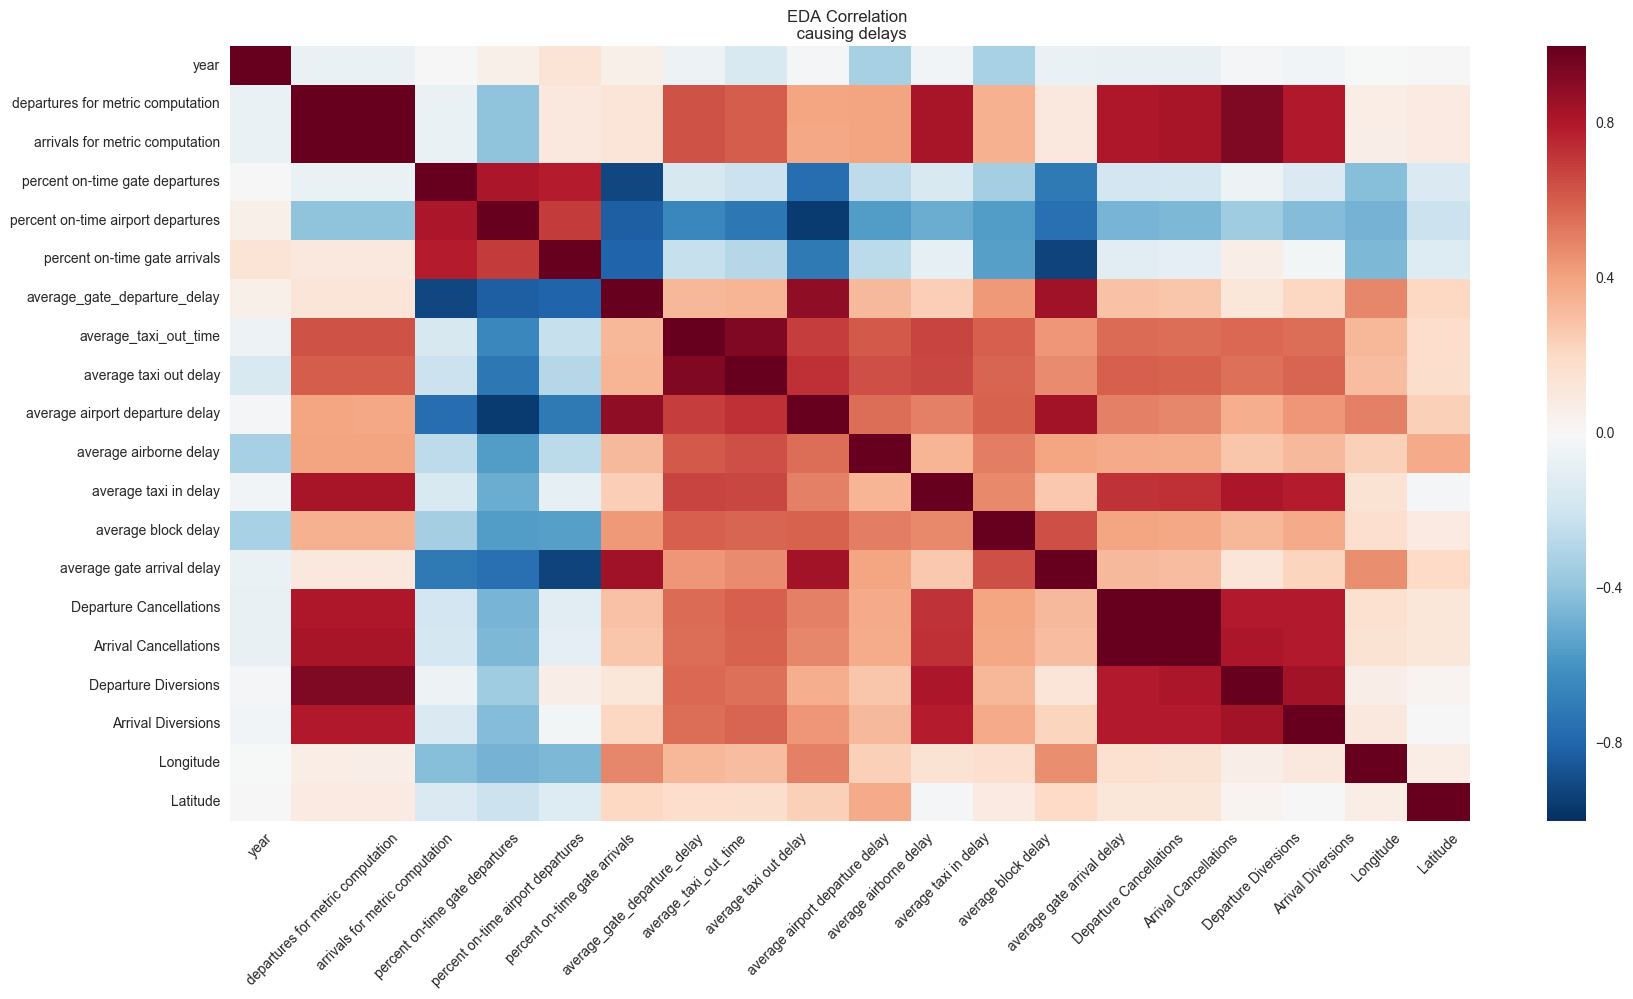

In [23]:
plt.figure(figsize=(20,10)) 
sns.heatmap(airport_merged_df.corr())
plt.title('EDA Correlation \n causing delays')
ticks = plt.xticks(rotation=45, ha='center')

I will drop year and latitude as they are not significantly correlated with other features. 

In [24]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
airport_merged_df['airport'] = le.fit_transform(airport_merged_df['airport'])

In [25]:
airport_df = airport_merged_df.copy()
del airport_df["year"]
del airport_df["Latitude"]
cols = airport_merged_df.columns
airport_df.head(1)

,airport,departures for metric computation,arrivals for metric computation,percent on-time gate departures,percent on-time airport departures,percent on-time gate arrivals,average_gate_departure_delay,average_taxi_out_time,average taxi out delay,average airport departure delay,average airborne delay,average taxi in delay,average block delay,average gate arrival delay,Departure Cancellations,Arrival Cancellations,Departure Diversions,Arrival Diversions,Longitude
0,0,53971,53818,0.803,0.7809,0.7921,10.38,9.89,2.43,12.1,2.46,0.83,2.55,10.87,242.0,235.0,71.0,46.0,-106.609194


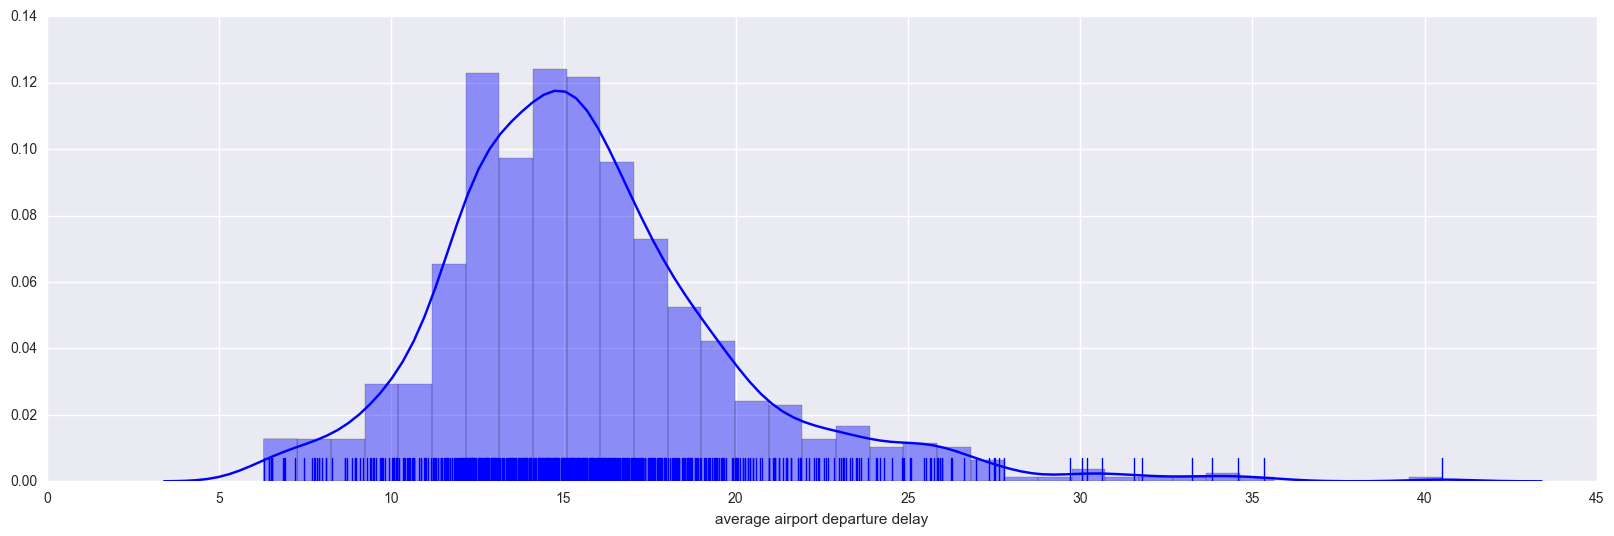

In [26]:
fig = plt.figure(figsize=(20,6)) 
sns.distplot(airport_df["average airport departure delay"], rug=True, color='b')

In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [28]:
X_scaled = StandardScaler().fit_transform(airport_df)
pca=PCA(n_components=2, random_state=42)
pca_df = pca.fit_transform(X_scaled)
pca

PCA(copy=True, iterated_power='auto', n_components=2, random_state=42,
  svd_solver='auto', tol=0.0, whiten=False)

In [29]:
pca_df = pd.DataFrame(pca_df,columns=["Dimension 1", "Dimension 2"])

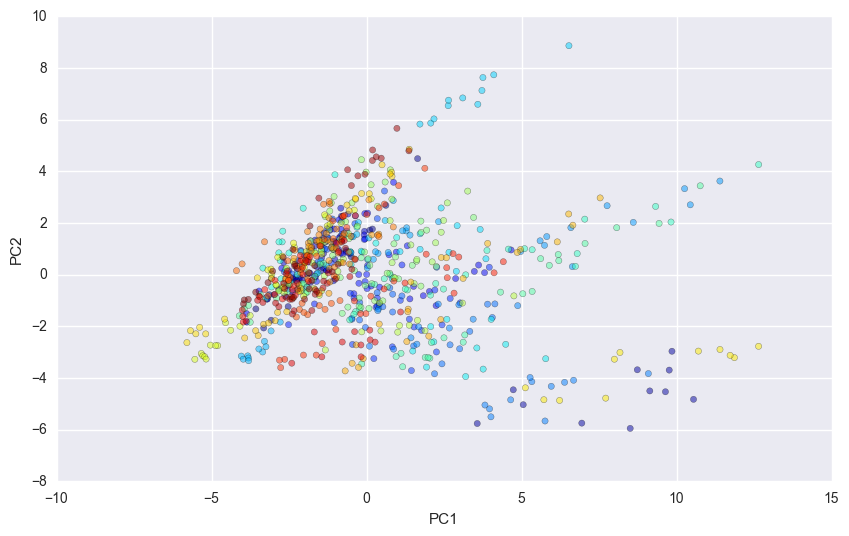

In [30]:
fig = plt.figure(figsize=(10,6)) 
plt.scatter(pca_df["Dimension 1"],pca_df["Dimension 2"], c=airport_df["airport"], alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')

In [31]:
X_scaled = StandardScaler().fit_transform(airport_df)
pca3=PCA(n_components=3, random_state=42)
pca3_df = pca3.fit_transform(X_scaled)
pca3

PCA(copy=True, iterated_power='auto', n_components=3, random_state=42,
  svd_solver='auto', tol=0.0, whiten=False)

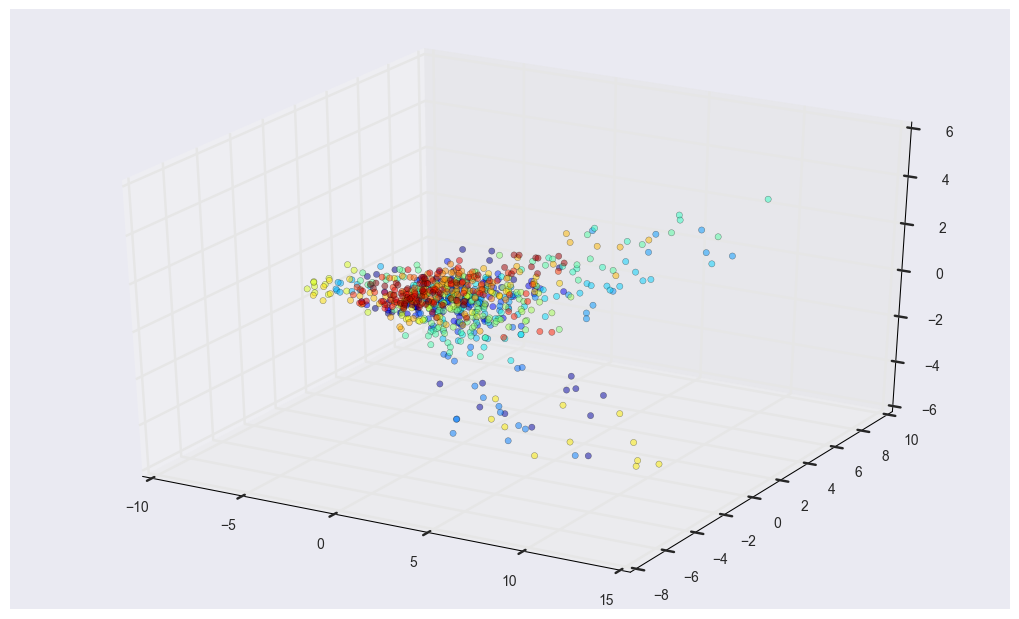

In [32]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,6)) 
my_axs = Axes3D(fig)
my_axs.scatter(pca3_df.T[0],pca3_df.T[1],pca3_df.T[2],c=airport_df["airport"],depthshade=True, alpha=0.5)

In [33]:
for ind in range(1,3):
    print 'The first {} components explain {}% of the variance.'.format(ind, sum(pca.explained_variance_ratio_[:ind])*100)

The first 1 components explain 49.1872528501% of the variance.
The first 2 components explain 71.8847823025% of the variance.


In [34]:
# Pricipal Component 1
pca_decomp_df = pd.DataFrame(zip(airport_df.columns.values, pca.components_[0]), columns=["Feature","PC1"])  
pca_decomp_df["PC2"] = pca.components_[1]
pca_decomp_df.sort_values(by=["PC1","PC2"], ascending=[False,False])

,Feature,PC1,PC2
9,average airport departure delay,0.281087,0.220784
8,average taxi out delay,0.272319,-0.028735
7,average_taxi_out_time,0.266740,-0.046657
14,Departure Cancellations,0.263797,-0.182880
15,Arrival Cancellations,0.261895,-0.193987
11,average taxi in delay,0.261120,-0.184533
1,departures for metric computation,0.251365,-0.276973
2,arrivals for metric computation,0.251058,-0.277555
17,Arrival Diversions,0.248052,-0.211751
16,Departure Diversions,0.241634,-0.274584


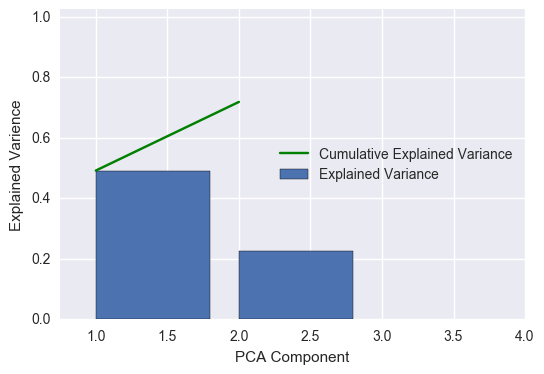

In [35]:
plt.figure()
plt.plot(range(1,3),np.cumsum(pca.explained_variance_ratio_), c='g')
plt.bar(range(1,3),pca.explained_variance_ratio_)
plt.xlim([.75, 4])
plt.ylim([0,1.025])
plt.xlabel('PCA Component')
plt.ylabel('Explained Varience')
plt.legend(['Cumulative Explained Variance','Explained Variance'],loc=7)

In [36]:
sum(pca.explained_variance_ratio_)

0.71884782302455152

In [37]:
from sklearn.manifold import TSNE  

In [38]:
X_scaled = StandardScaler().fit_transform(airport_df)
tsne = TSNE(n_components=2)

In [39]:
tsne_X = tsne.fit_transform(X_scaled)
tsne_df = pd.DataFrame({'X1':tsne_X[:,0],'X2':tsne_X[:,1]})

In [40]:
import matplotlib.pylab as plt1

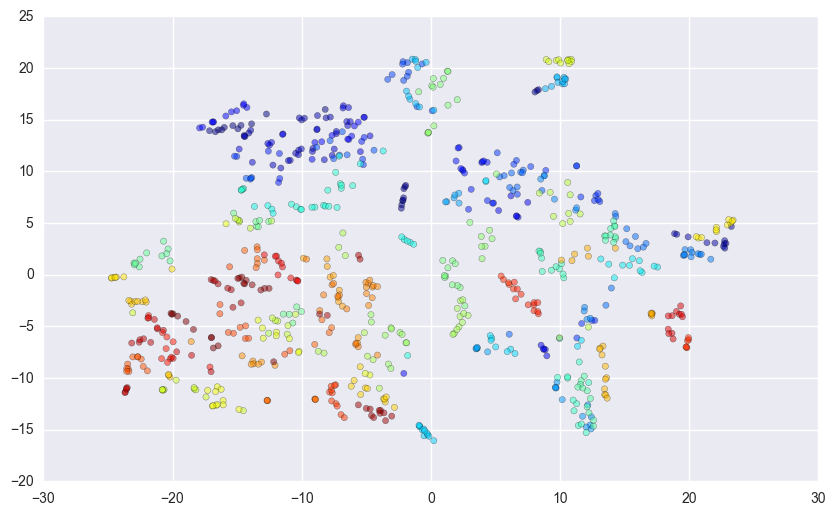

In [41]:
fig = plt1.figure(figsize=(10,6)) 
plt.scatter(tsne_df["X1"],tsne_df["X2"],c=airport_df["airport"], alpha=0.5)

#### TSNE with 3 components

In [42]:
X_scaled = StandardScaler().fit_transform(airport_df)
tsne3 = TSNE(n_components=3,random_state=42)
tsne3_X =tsne3.fit_transform(X_scaled)
tsne3_df = pd.DataFrame({'X1':tsne3_X[:,0],'X2':tsne3_X[:,1], 'X3':tsne3_X[:,2] })

#plt.scatter(tsne3_df[0],tsne3_df[1],tsne3_df[1] alpha=0.7)

In [43]:
airport_df.shape

(799, 19)

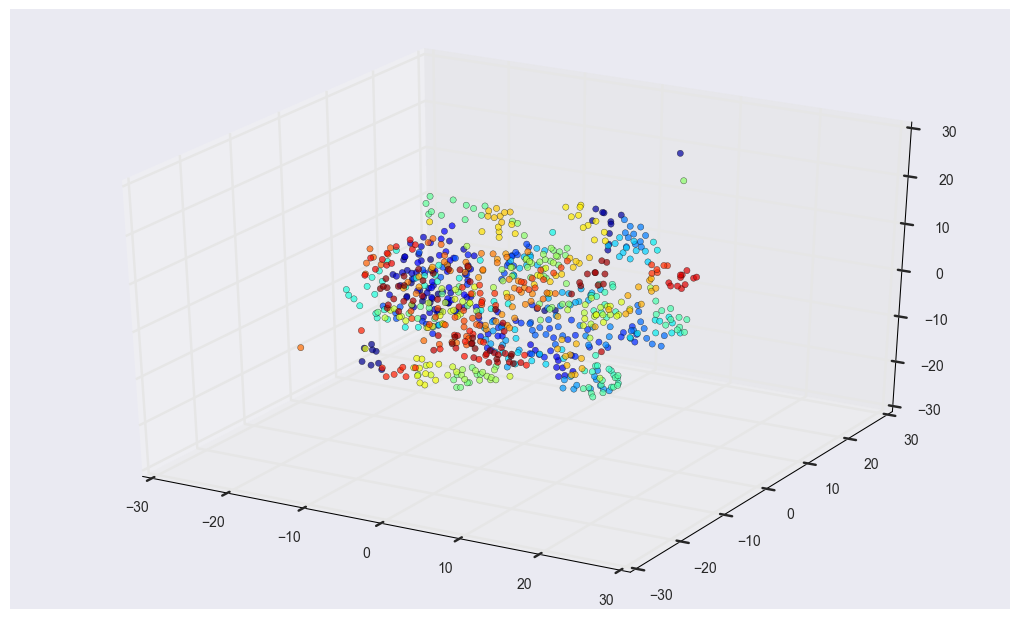

In [44]:
fig = plt1.figure(figsize=(10,6)) 
my_axs = Axes3D(fig)
my_axs.scatter(tsne3_df["X1"],tsne3_df["X2"],tsne3_df["X3"],c=airport_df["airport"].values, alpha=0.7)

In [45]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
import renders as rs
from IPython.display import display

In [46]:
def k_means_fit_score(X, k):
    rs.plots_for_n_clusters(X, k)

('For n_clusters =', 2, 'The average silhouette_score is :', 0.51072513406637987)
('For n_clusters =', 3, 'The average silhouette_score is :', 0.34486352507510631)
('For n_clusters =', 4, 'The average silhouette_score is :', 0.38874590558560124)


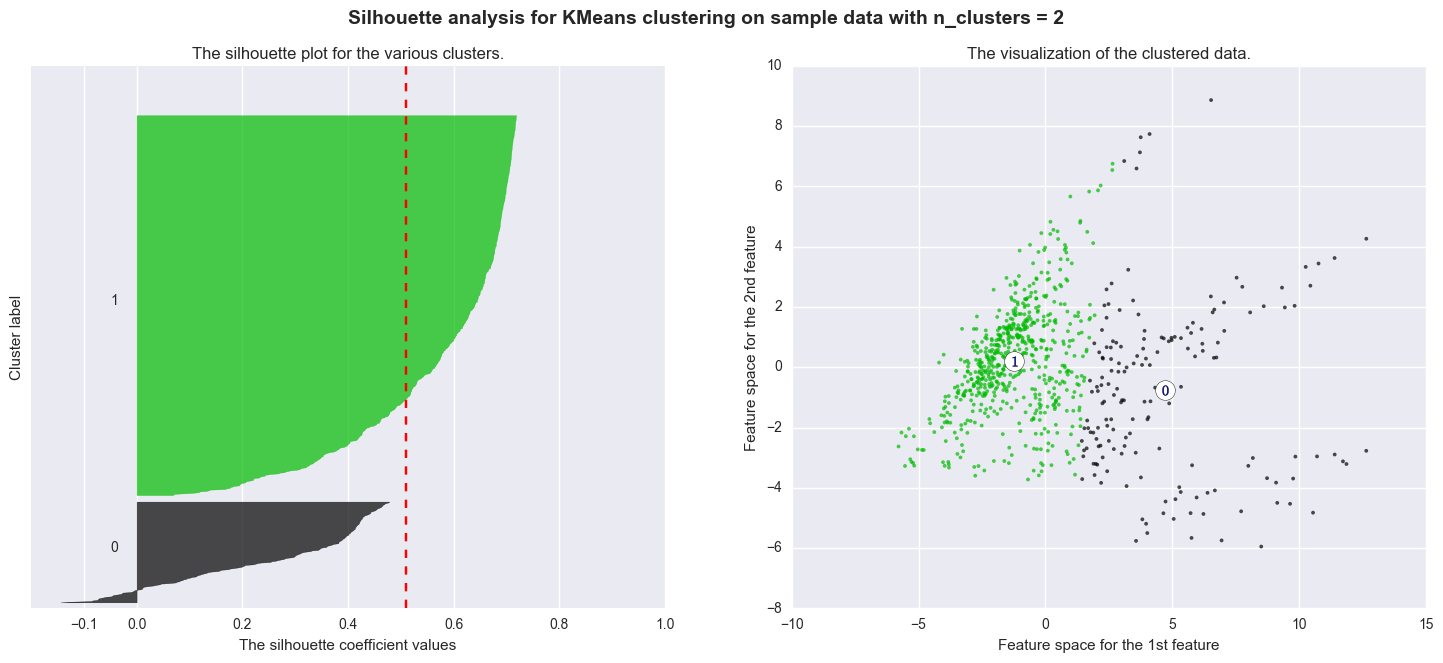

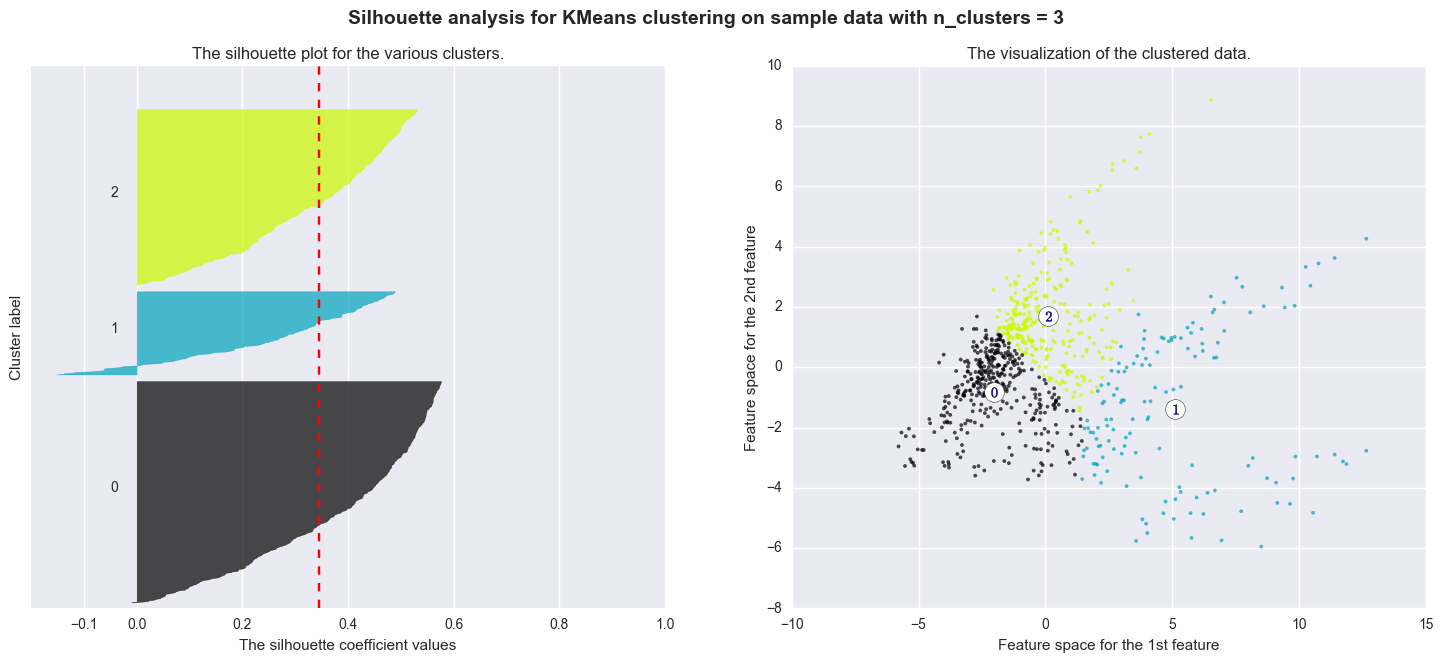

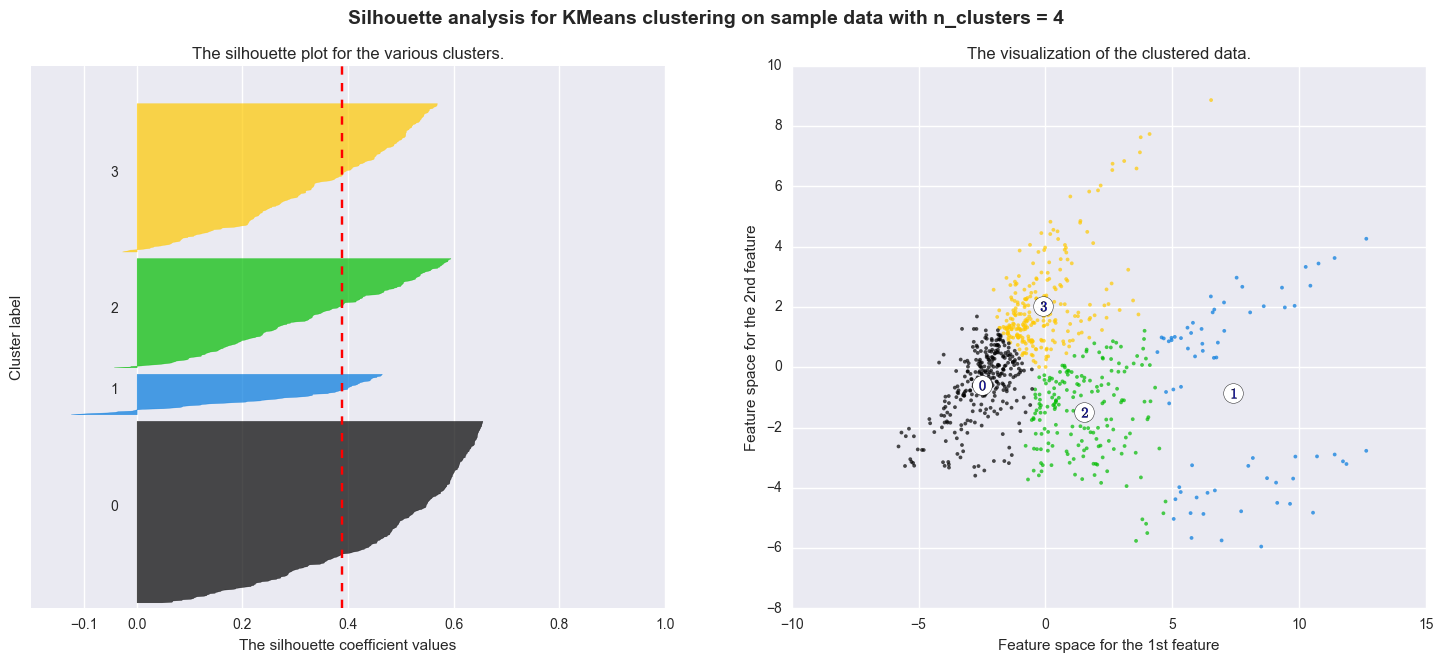

In [47]:
ks = range(2,5)
for k in ks:
    k_means_fit_score(pca_df, k)

**The silhouette score is best with 2 clusters and therefore it appears clustering analysis is approprirate with 2clusters.**

In [48]:
km2 = KMeans(n_clusters=2, random_state=42)
km2.fit(pca_df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

In [49]:
X=airport_df.copy()
y=km2.labels_

In [50]:
airport_df['label']=km2.labels_

In [51]:
airport_df.groupby("label")["airport"].count()

label
0    168
1    631
Name: airport, dtype: int64

### I will use RandomForest Classifier

In [52]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

In [53]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,random_state=42)
RFC = RandomForestClassifier(n_estimators=500)
RFC.fit(Xtrain,ytrain)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [54]:
RFC.score(Xtrain,ytrain)

1.0

In [55]:
RFC.score(Xtest,ytest)

0.98499999999999999

In [56]:
feature_imp =[ val for val in RFC.feature_importances_]

In [57]:
results_df = pd.DataFrame([X.columns,feature_imp])
results_df = results_df.T
results_df.sort_values(1,ascending=False)

,0,1
14,Departure Cancellations,0.171261
15,Arrival Cancellations,0.128284
1,departures for metric computation,0.106635
2,arrivals for metric computation,0.0980305
11,average taxi in delay,0.0909299
17,Arrival Diversions,0.0692567
7,average_taxi_out_time,0.0577916
9,average airport departure delay,0.0541551
8,average taxi out delay,0.0484358
4,percent on-time airport departures,0.0323093


In [58]:
ypred=RFC.predict(Xtest)

In [59]:
print(metrics.classification_report(ypred, ytest))

             precision    recall  f1-score   support

          0       0.94      1.00      0.97        47
          1       1.00      0.98      0.99       153

avg / total       0.99      0.98      0.99       200



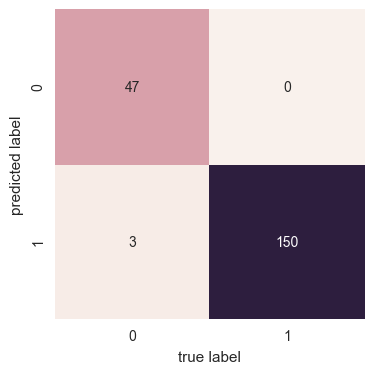

In [60]:
mat = metrics.confusion_matrix(ytest,ypred)
sns.heatmap(mat.T,square=True,annot=True,fmt='d',cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')

Based on the Randomforest classifier we receive very high test score as well as accuracy in labeling our data. We can group these ariports in two categories. 

The attributes that contributes to delay paramters are defined in our PCA analysis some of them specifically are departure cancellation, taxi out delay, arrival cancelations, average taxi in delay, longitude, departures, arricals and diversions  